In [88]:
from tensorflow import keras
from keras.datasets import reuters
from keras.utils import to_categorical
from keras import layers
import numpy as np
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping

In [34]:
def vectorize_sequences(sequences, dimension=10_000):
  '''
  Takes a list of word-encoded document samples and multi-hot encodes (yields one vector of binary results for a list of terms)
  ----
  Example input = [1, 5, 3]
  Resulting vector = [0, 1, 0, 1, 0, 1]
  '''
  results = np.zeros((len(sequences), dimension))
  for i, sequence in enumerate(sequences):
    for j in sequence:
      results[i, j] = 1
  return results


In [35]:
(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words = 10_000)

In [36]:
len(train_data)

8982

In [37]:
len(test_data)

2246

array([ 3,  4,  3,  4,  4,  4,  4,  3,  3, 16])

In [38]:
#train_data[10]

In [39]:
#Decoding
word_index = reuters.get_word_index()

In [40]:
list(word_index.items())[:5]

[('mdbl', 10996),
 ('fawc', 16260),
 ('degussa', 12089),
 ('woods', 8803),
 ('hanging', 13796)]

In [41]:
reverse_word_index = dict([(value, key) for (key,value) in word_index.items()])

Not necessary, but nice to know how to decode

In [42]:
decoded_newswire = ' '.join([reverse_word_index.get(i-3, '?') for i in train_data[1]])

In [43]:
decoded_newswire

'? generale de banque sa lt ? br and lt heller overseas corp of chicago have each taken 50 pct stakes in ? company sa ? factors generale de banque said in a statement it gave no financial details of the transaction sa ? ? turnover in 1986 was 17 5 billion belgian francs reuter 3'

Vectorize the training and test data so that:

-    every input is a tensor of the same shape (vector of length = max amount of words we care about) and every encoded word is hot-encoded into that vector (word index 5 appears as a 1 in index 5 if it is present and so on)



In [49]:
x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)

**One** hot encode the labels as well (every label becomes a vector of max length = number of classes)

In [51]:
y_train = to_categorical(train_labels)
y_test = to_categorical(test_labels)


Note: Using to_categorical (categorical encoding) you must use the categorical_crossentropy loss function when compiline.

If you choose to use the following and just pass as an integer array (probably easier) you can then use the newer sparse_categorical_crossentropy loss function)

In [ ]:
# y_train = np.array(train_labels)
# y_test = np.array(test_labels)

array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

Reminder: every layer in a neural network is dependent on the output of the one before it - if some useful representation is lost in the first layer, the second+ will never recover it.

More classes (multiclass classification) should use more nodes/units for this reason.

**Never use less units in a Dense layer than there are output class possibilities**

In [56]:
model = keras.Sequential([
    layers.Dense(64, activation='relu'),
    layers.Dense(64, activation = 'relu'),
    layers.Dense(46, activation='softmax')
])

In [60]:
model.compile(optimizer='rmsprop',
              loss = 'categorical_crossentropy',
              metrics=['accuracy'])

Set aside some validation data

In [63]:
x_val = x_train[:1000]
partial_x_train = x_train[1000:]
y_val = y_train[:1000]
partial_y_train = y_train[1000:]

In [69]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs = 20,
                    batch_size = 512,
                    validation_data = (x_val, y_val))



Epoch 1/20
16/16 [==============================] - 3s 115ms/step - loss: 2.6802 - accuracy: 0.4689 - val_loss: 1.7905 - val_accuracy: 0.6160
Epoch 2/20
16/16 [==============================] - 1s 89ms/step - loss: 1.5023 - accuracy: 0.6828 - val_loss: 1.3593 - val_accuracy: 0.6900
Epoch 3/20
16/16 [==============================] - 3s 209ms/step - loss: 1.1556 - accuracy: 0.7539 - val_loss: 1.1979 - val_accuracy: 0.7290
Epoch 4/20
16/16 [==============================] - 1s 92ms/step - loss: 0.9526 - accuracy: 0.7970 - val_loss: 1.0885 - val_accuracy: 0.7740
Epoch 5/20
16/16 [==============================] - 1s 69ms/step - loss: 0.7906 - accuracy: 0.8334 - val_loss: 1.0242 - val_accuracy: 0.7840
Epoch 6/20
16/16 [==============================] - 1s 66ms/step - loss: 0.6624 - accuracy: 0.8602 - val_loss: 0.9519 - val_accuracy: 0.8010
Epoch 7/20
16/16 [==============================] - 1s 67ms/step - loss: 0.5556 - accuracy: 0.8816 - val_loss: 0.9175 - val_accuracy: 0.7990
Epoch 8/20


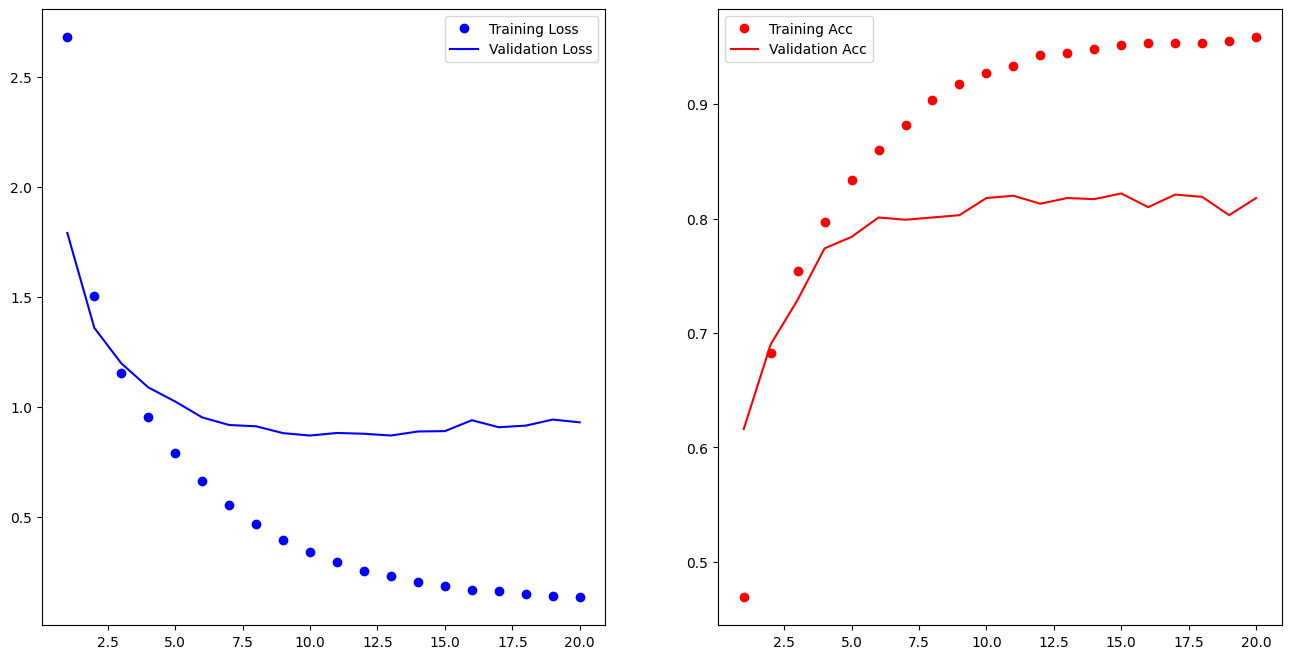

In [87]:
fig, axs = plt.subplots(1,2, figsize=(16,8))
loss = history.history['loss']
val_loss = history.history['val_loss']
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(loss) + 1)

axs[0].plot(epochs, loss, "bo", label="Training Loss")
axs[0].plot(epochs, val_loss, "b", label="Validation Loss")
axs[0].legend();

axs[1].plot(epochs, acc, "ro", label="Training Acc")
axs[1].plot(epochs, val_acc, "r", label="Validation Acc")
axs[1].legend();

Overfitting appears to happen at 10 epochs, let's aim to grab the best one - with some EarlyStopping experimentation on top of the original exercise

In [100]:
es = EarlyStopping(
    monitor='val_accuracy',
    patience = 2,
    verbose = 1,
    restore_best_weights=True,
    start_from_epoch=5
)
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs = 20,
                    batch_size = 512,
                    validation_data = (x_val, y_val),
                    callbacks = [es]
)


Epoch 1/20
16/16 [==============================] - 2s 128ms/step - loss: 0.2848 - accuracy: 0.9357 - val_loss: 0.8528 - val_accuracy: 0.8190
Epoch 2/20
16/16 [==============================] - 2s 118ms/step - loss: 0.2405 - accuracy: 0.9450 - val_loss: 0.8574 - val_accuracy: 0.8240
Epoch 3/20
16/16 [==============================] - 1s 89ms/step - loss: 0.2167 - accuracy: 0.9474 - val_loss: 0.8668 - val_accuracy: 0.8160
Epoch 4/20
16/16 [==============================] - 1s 85ms/step - loss: 0.1939 - accuracy: 0.9489 - val_loss: 0.8758 - val_accuracy: 0.8260
Epoch 5/20
16/16 [==============================] - 1s 89ms/step - loss: 0.1737 - accuracy: 0.9519 - val_loss: 0.9318 - val_accuracy: 0.8040
Epoch 6/20
16/16 [==============================] - 3s 159ms/step - loss: 0.1661 - accuracy: 0.9534 - val_loss: 0.9889 - val_accuracy: 0.8020
Epoch 7/20
16/16 [==============================] - 3s 186ms/step - loss: 0.1475 - accuracy: 0.9569 - val_loss: 0.9286 - val_accuracy: 0.8120
Epoch 8/2

In [101]:
model.evaluate(x_test, y_test)

71/71 [==============================] - 0s 5ms/step - loss: 1.0113 - accuracy: 0.7952


[1.011296272277832, 0.7951914668083191]

In [92]:
predictions = model.predict(x_test)

71/71 [==============================] - 1s 5ms/step


In [96]:
predictions[0].shape

(46,)

Experimenting with different NN architecture

Epoch 1/20
16/16 [==============================] - 2s 108ms/step - loss: 2.3570 - accuracy: 0.4975 - val_loss: 1.5745 - val_accuracy: 0.6610
Epoch 2/20
16/16 [==============================] - 2s 115ms/step - loss: 1.3403 - accuracy: 0.7116 - val_loss: 1.2354 - val_accuracy: 0.7320
Epoch 3/20
16/16 [==============================] - 2s 143ms/step - loss: 1.0053 - accuracy: 0.7813 - val_loss: 1.0724 - val_accuracy: 0.7760
Epoch 4/20
16/16 [==============================] - 2s 93ms/step - loss: 0.7969 - accuracy: 0.8229 - val_loss: 0.9931 - val_accuracy: 0.7840
Epoch 5/20
16/16 [==============================] - 1s 81ms/step - loss: 0.6252 - accuracy: 0.8668 - val_loss: 0.9861 - val_accuracy: 0.7700
Epoch 6/20
16/16 [==============================] - 1s 89ms/step - loss: 0.5077 - accuracy: 0.8940 - val_loss: 0.9096 - val_accuracy: 0.7980
Epoch 7/20
16/16 [==============================] - 1s 83ms/step - loss: 0.4117 - accuracy: 0.9123 - val_loss: 0.9059 - val_accuracy: 0.7970
Epoch 8/20

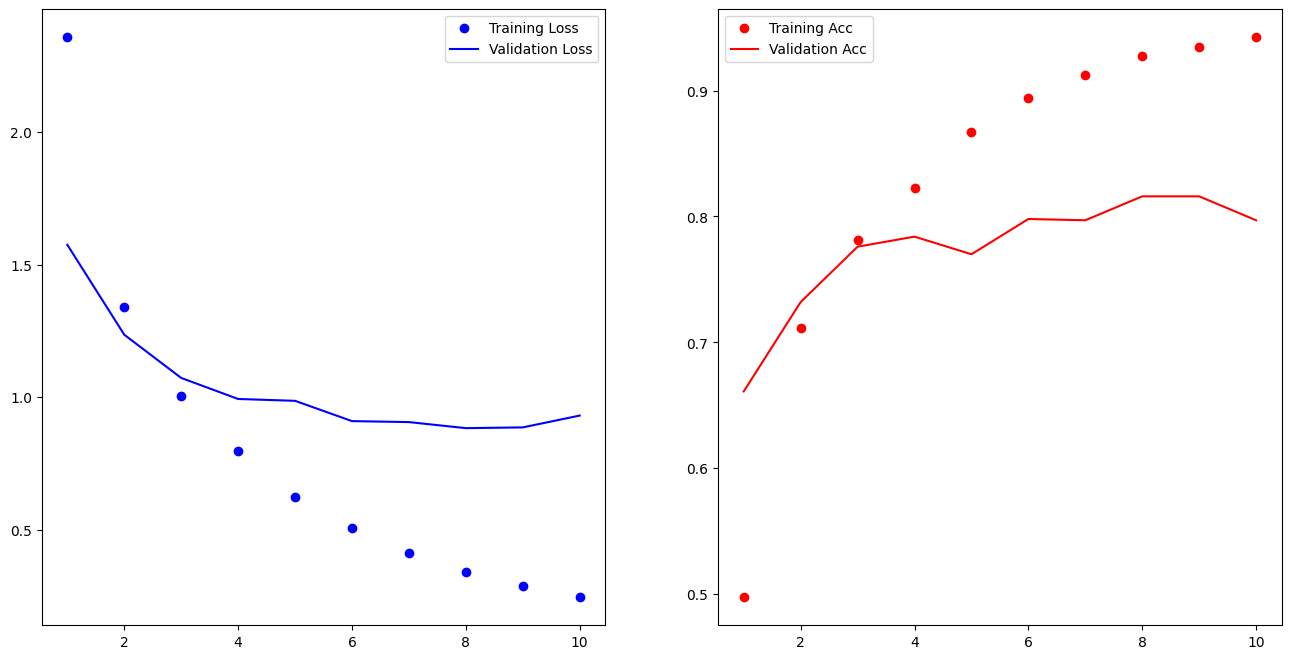

In [98]:
model = keras.Sequential([
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation = 'relu'),
    layers.Dense(46, activation='softmax')
])
model.compile(optimizer='rmsprop',
              loss = 'categorical_crossentropy',
              metrics=['accuracy'])

es = EarlyStopping(
    monitor='val_accuracy',
    patience = 2,
    verbose = 1,
    restore_best_weights=True,
    start_from_epoch=5
)
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs = 20,
                    batch_size = 512,
                    validation_data = (x_val, y_val),
                    callbacks = [es]
)

fig, axs = plt.subplots(1,2, figsize=(16,8))
loss = history.history['loss']
val_loss = history.history['val_loss']
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(loss) + 1)

axs[0].plot(epochs, loss, "bo", label="Training Loss")
axs[0].plot(epochs, val_loss, "b", label="Validation Loss")
axs[0].legend();

axs[1].plot(epochs, acc, "ro", label="Training Acc")
axs[1].plot(epochs, val_acc, "r", label="Validation Acc")
axs[1].legend();

In [99]:
results = model.evaluate(x_test, y_test)

71/71 [==============================] - 1s 7ms/step - loss: 0.9485 - accuracy: 0.7854
